---
# Panoptic Segmentation and Object Extraction Pipeline

**Notebook name**: panoptic_segmentation.ipynb  
**Author**: Dr. Vishal Sharma, SARDA DataWorks

---

## 1. Introduction  

This notebook demonstrates how to use open-source Detectron2's panoptic segmentation model to identify and extract specific objects from an image, then composite those objects onto a transparent background. This is particularly useful for image editing, object isolation, and various computer vision tasks.

<p style='background-color:#FFCCCB'>
    <b>&nbsp;&nbsp;Note:</b> This code is configured to run on CPU. If you want to run it on a GPU, you need to change the configuration in the <code>get_cfg_panoptic</code> function by setting<br>&nbsp;&nbsp;<code>cfg.MODEL.DEVICE = 'cuda'</code>.
    <br>
<p>

## 2. Code Documentation

**Platform**  
Detectron2 by Facebook Research ([GitHub](https://github.com/facebookresearch/detectron2))  

**Model**  
Panoptic Segmentation ([Panoptic Segmentation Paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Kirillov_Panoptic_Segmentation_CVPR_2019_paper.pdf))  

**Description**  
Dr. Vishal Sharma, Director of Data and AI at SARDA DataWorks, developed this pipeline to identify and extract objects from an image using the panoptic segmentation model from the Detectron2 platform. Users can specify the target classes to crop corresponding objects from the image and construct an image of the cropped objects on a transparent background.

**Key Steps:**  

**1. Configuration:** Setting up the Detectron2 panoptic segmentation model.  
**2. Prediction:** Running the model on the input image to get segmentation results.  
**3. Mask Extraction:** Extracting masks for specified classes.  
**4. Mask Application:** Applying the masks to the original image to isolate objects.  
**5. Combination:** Combining the individual object masks into a single image with a transparent background.  
**6. Saving:** Saving the final composited image.  

---


## 3. Code Walkthrough

### 3.1. Setup

This section sets up the environment by importing necessary libraries and configuring the Detectron2 logger.

In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import torch

# Print Versions
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
print("torch: ", TORCH_VERSION,)
print("detectron2: ", detectron2.__version__)
print("OpenCV: ", cv2.__version__)

torch:  2.3
detectron2:  0.6
OpenCV:  4.10.0


### 3.2. Model Configuration

Configure the Detectron2 panoptic segmentation model with a pre-trained backbone.

In [2]:
# === Configure Panoptic Segmentation model of Detectron2 - FPN R 101 3x ======================================
def get_cfg_panoptic():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
    cfg.MODEL.DEVICE = 'cpu'
    return cfg

### 3.3. Model Prediction

Run the panoptic segmentation model on the input image.

In [3]:
# === Get prediction using panoptic segmentation model ========================================================
def get_predictor_outputs_panoptic(cfg, im):
    predictor = DefaultPredictor(cfg)
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    return panoptic_seg, segments_info

### 3.4. Visualize Inference

View the model's inference of the image

In [9]:
# === Visualize predictions of Panoptic Segmentation ==========================================================
def visualize_predictions_panoptic(im, cfg, panoptic_seg, segments_info, metadata):
    v = Visualizer(im[:, :, ::-1], metadata, scale=1.2)
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    cv2.imshow('image', out.get_image()[:, :, ::-1])
    # waiting for key event
    cv2.waitKey(0)
    # destroying all windows
    cv2.destroyAllWindows()
    return out

### 3.5. Mask Extraction

Extract masks for the specified object classes from the segmentation output.

In [5]:
#  === Get masks for all instances of the specified class =====================================================
def get_masks_for_classes(cfg, panoptic_seg, segments_info, class_names, metadata):    
    masks = {class_name: [] for class_name in class_names}
    # Find the segment information for the class of interest
    for segment_info in segments_info:
        category_id = segment_info["category_id"]
        class_name = metadata.thing_classes[category_id]
        
        if class_name in class_names:
            mask = panoptic_seg == segment_info["id"]
            masks[class_name].append(mask)
    return masks

### 3.6. Mask Application

Apply the masks to the original image to create RGBA images.

In [6]:
# === Combine multiple RGBA masks into one image ==============================================================
def combine_masks(masks, original_image):
    combined_image = np.zeros((original_image.shape[0], original_image.shape[1], 4), dtype=np.uint8)
    
    for class_name, class_masks in masks.items():
        for mask in class_masks:
            mask_rgba, (x1, y1, x2, y2) = apply_mask(mask, original_image)
            combined_image[y1:y2, x1:x2] = np.maximum(combined_image[y1:y2, x1:x2], mask_rgba)
    
    return combined_image

### 3.7. Combine Masks

Combine the individual object masks into one image.

In [7]:
# === Apply mask to original image ============================================================================
def apply_mask(mask, original_image):
    # Ensure mask is a boolean array
    mask = mask.cpu().numpy()

    # Get bounding box coordinates
    y_indices, x_indices = np.where(mask)
    y1, y2 = y_indices.min(), y_indices.max() + 1
    x1, x2 = x_indices.min(), x_indices.max() + 1

    # Crop the original image to the bounding box
    cropped_image = original_image[y1:y2, x1:x2]

    # Resize mask to match the size of the bounding box
    mask_resized = mask[y1:y2, x1:x2]

    # Create an RGBA image with the same height and width as the cropped image
    mask_rgba = np.zeros((mask_resized.shape[0], mask_resized.shape[1], 4), dtype=np.uint8)

    # Fill the mask with the original image colors where mask is 1
    mask_rgba[mask_resized > 0, :3] = cropped_image[mask_resized > 0]
    mask_rgba[mask_resized > 0, 3] = 255  # Set alpha channel to 255 (opaque) for the mask area

    return mask_rgba, (x1, y1, x2, y2)

## 4. Main Execution

The main section of the code specifies the target classes, reads the input image, processes it, and saves the output image.

[06/14 02:07:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


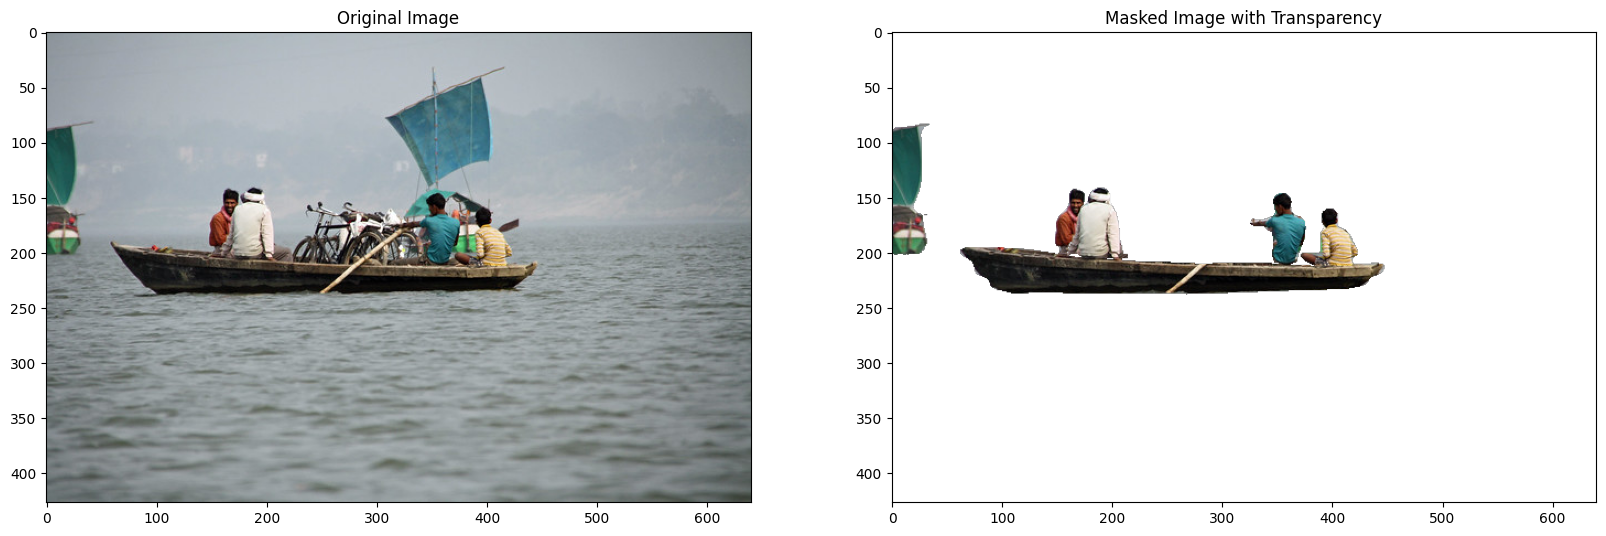

True

In [13]:
# Main
class_names = ['boat', 'person']                                # user specified object for extraction

# user specified image path
im_path = '../images/originals/6743930825_20b705cc5c_z.jpg'
if not os.path.isfile(im_path):
    raise FileNotFoundError("Image file not found in path")
    
im = cv2.imread(im_path)                                       # Read image data
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# === Start processing =================================================================================
cfg = get_cfg_panoptic()
panoptic_seg, segments_info = get_predictor_outputs_panoptic(cfg, im)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
out = visualize_predictions_panoptic(im, cfg, panoptic_seg, segments_info, metadata)
masks = get_masks_for_classes(cfg, panoptic_seg, segments_info, class_names, metadata)
final_masked_image = combine_masks(masks, im_rgb)

# === Plotting the results ==============================================================================
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(im_rgb)

plt.subplot(1, 2, 2)
plt.title("Masked Image with Transparent Background")
plt.imshow(final_masked_image)
plt.show()

# === Save image file ====================================================================================
output_path = '../images/outputs/'
os.makedirs(output_path, exist_ok=True)
# Convert from RGBA to BGRA
final_masked_image_bgra = cv2.cvtColor(final_masked_image, cv2.COLOR_RGBA2BGRA)
cv2.imwrite(f"{output_path}/example_masked.jpg",final_masked_image_bgra)                # Save isolated object image
cv2.imwrite(f"{output_path}/example_panoptic.jpg", out.get_image()[:, :, ::-1])         # Save panoptic segmentation inference image

---

## 5. Conclusion

This notebook provides a comprehensive pipeline for extracting specific objects from an image using panoptic segmentation and compositing them onto a transparent background. The modular structure allows easy customization for different classes and images.

---

## Additional Notes

- **Dependencies:** Ensure you have all required dependencies installed (Detectron2, OpenCV, PyTorch, etc.).
- **Performance:** For large images or numerous objects, consider running the code on a machine with adequate computational resources.
- **Output Format:** The final image is saved in PNG format to preserve the transparency of the background.
- **Device Configuration:** This code is set to run on CPU. To run on GPU, change `cfg.MODEL.DEVICE = 'cpu'` to `cfg.MODEL.DEVICE = 'cuda'` in the `get_cfg_panoptic` function.

---